In [1]:
import matplotlib.pyplot as plt
import torchvision
from pathlib import Path
import torch

from torch import nn
from torchvision import transforms
from scripts import data_setup, engine, utils
import torchinfo


c:\Users\asaph\Documents\CNN Folder\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#VGG16, GoogLenet, AlexNet, ResNeXt, efficientnet and DenseNet are the architectures

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
data_path = Path("data/")
image_path = data_path / "soil_images_sorted"

In [5]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [6]:
#HyperParameters
batch_Size = 8
learning_rate = 0.0005
epochS = 20
dropout_prob = 0.5

In [7]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=batch_Size) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x260aade9070>,
 ['high', 'low', 'medium'])

In [9]:
# OLD: Setup the model with pretrained weights and send it to the target device (this was prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD method (with pretrained=True)

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

In [10]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
# for param in model.features.parameters():
#     param.requires_grad = False



In [11]:
# Check if any parameter in model.features will compute gradients
any_grad_computation = not any(param.requires_grad for param in model.features.parameters())
any_grad_computation

False

In [12]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = nn.Sequential(
    nn.Dropout(p=dropout_prob, inplace=True), 
    nn.Linear(in_features=1280, 
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [13]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=epochS,
                       device=device)

#write to the csv file


# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:26<08:32, 26.99s/it]

Epoch: 1 | train_loss: 0.6712 | train_acc: 0.7262 | test_loss: 0.3744 | test_acc: 0.8523


 10%|█         | 2/20 [00:52<07:50, 26.16s/it]

Epoch: 2 | train_loss: 0.3618 | train_acc: 0.8631 | test_loss: 0.2477 | test_acc: 0.9091


 15%|█▌        | 3/20 [01:17<07:15, 25.61s/it]

Epoch: 3 | train_loss: 0.2768 | train_acc: 0.8988 | test_loss: 0.3157 | test_acc: 0.8295


 20%|██        | 4/20 [01:43<06:49, 25.57s/it]

Epoch: 4 | train_loss: 0.2145 | train_acc: 0.9167 | test_loss: 0.1598 | test_acc: 0.9205


 25%|██▌       | 5/20 [02:10<06:36, 26.41s/it]

Epoch: 5 | train_loss: 0.1469 | train_acc: 0.9554 | test_loss: 0.3141 | test_acc: 0.8864


 30%|███       | 6/20 [02:36<06:04, 26.03s/it]

Epoch: 6 | train_loss: 0.1144 | train_acc: 0.9643 | test_loss: 0.1453 | test_acc: 0.9318


 35%|███▌      | 7/20 [03:01<05:36, 25.88s/it]

Epoch: 7 | train_loss: 0.1447 | train_acc: 0.9494 | test_loss: 0.2782 | test_acc: 0.9091


 40%|████      | 8/20 [03:28<05:13, 26.09s/it]

Epoch: 8 | train_loss: 0.2414 | train_acc: 0.9226 | test_loss: 0.2668 | test_acc: 0.8750


 45%|████▌     | 9/20 [03:54<04:45, 26.00s/it]

Epoch: 9 | train_loss: 0.0995 | train_acc: 0.9702 | test_loss: 0.1334 | test_acc: 0.9318


 50%|█████     | 10/20 [04:22<04:28, 26.85s/it]

Epoch: 10 | train_loss: 0.1118 | train_acc: 0.9673 | test_loss: 0.2523 | test_acc: 0.9091


 55%|█████▌    | 11/20 [04:48<03:57, 26.41s/it]

Epoch: 11 | train_loss: 0.1029 | train_acc: 0.9702 | test_loss: 0.1778 | test_acc: 0.9205


 60%|██████    | 12/20 [05:13<03:28, 26.08s/it]

Epoch: 12 | train_loss: 0.1127 | train_acc: 0.9673 | test_loss: 0.0874 | test_acc: 0.9659


 65%|██████▌   | 13/20 [05:40<03:03, 26.24s/it]

Epoch: 13 | train_loss: 0.1214 | train_acc: 0.9673 | test_loss: 0.2032 | test_acc: 0.9205


 70%|███████   | 14/20 [06:06<02:38, 26.36s/it]

Epoch: 14 | train_loss: 0.0752 | train_acc: 0.9732 | test_loss: 0.2115 | test_acc: 0.9318


 75%|███████▌  | 15/20 [06:33<02:11, 26.39s/it]

Epoch: 15 | train_loss: 0.0742 | train_acc: 0.9732 | test_loss: 0.0933 | test_acc: 0.9545


 80%|████████  | 16/20 [06:59<01:45, 26.35s/it]

Epoch: 16 | train_loss: 0.0809 | train_acc: 0.9762 | test_loss: 0.1069 | test_acc: 0.9545


 85%|████████▌ | 17/20 [07:27<01:20, 26.76s/it]

Epoch: 17 | train_loss: 0.0554 | train_acc: 0.9821 | test_loss: 0.1432 | test_acc: 0.9659


 90%|█████████ | 18/20 [07:54<00:53, 26.91s/it]

Epoch: 18 | train_loss: 0.2470 | train_acc: 0.9226 | test_loss: 0.2721 | test_acc: 0.8864


 95%|█████████▌| 19/20 [08:20<00:26, 26.61s/it]

Epoch: 19 | train_loss: 0.1557 | train_acc: 0.9435 | test_loss: 0.2466 | test_acc: 0.9091


100%|██████████| 20/20 [08:46<00:00, 26.32s/it]

Epoch: 20 | train_loss: 0.0797 | train_acc: 0.9792 | test_loss: 0.2406 | test_acc: 0.8864
[INFO] Total training time: 526.395 seconds


In [15]:
utils.write_result_csv("../model_results_csvs/efficientnet.csv",
                       batch_Size,
                       learning_rate,
                       epochS,
                       dropout_prob,
                       any_grad_computation,
                    #results
                        results["train_loss"],
                        results["train_acc"],
                        results["test_loss"],
                        results["test_acc"])

Inserted new data in ../model_results_csvs/efficientnet.csv


In [16]:
from winsound import Beep
Beep(300, 800)

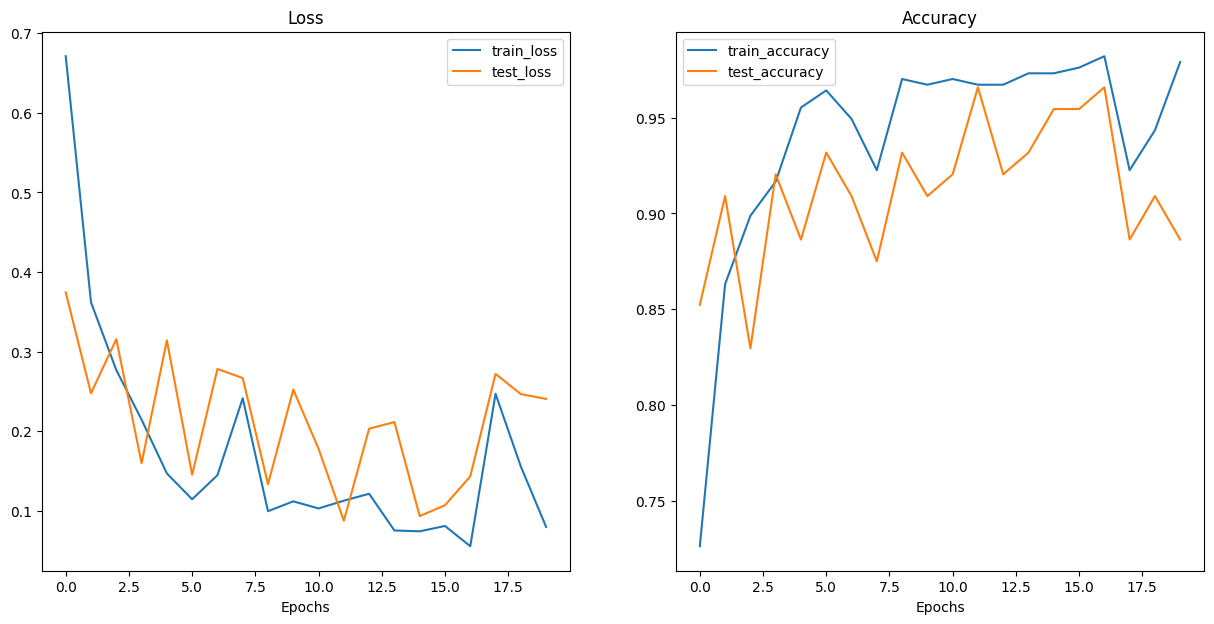

In [17]:
from scripts.helper_functions import plot_loss_curves

plot_loss_curves(results)

In [18]:
utils.save_model(model=model,
                 target_dir="models",
                 model_name="efficientNet1.pth")

[INFO] Saving model to: models\efficientNet1.pth
